In [73]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

## Data Load (using WFDB)

MIT-BIH Dataset은 Train data와 Annotation이 존재, 따라서 Annotation에 맞는 window를 설정

In [3]:
# Data Extract From Physionet *.dat

input_path = "../physionet/mit-bih_arr/1.0.0/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [155]:
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

In [199]:
window_size = 320

# Ref : Heartbeat classification fusing temporal and morphological information of ECGs via ensemble of classifiers
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

ANN_DICT = {0:"N", 1:"S", 2:"V", 3:"F", 4:"Q", 5:"-"}

def extract_from_sbj(idx):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=0)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=0).sample)[1:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=0).symbol)[1:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)
    
    """
    0 : N | 1 : S | 2 : V | 3 : F | 4 : Q
    """
    for i,sym in enumerate(record_ann_sym):
        if sym in NORMAL_ANN:
            record_ann_sym[i] = 0
        elif sym in SUPRA_ANN:
            record_ann_sym[i] = 1
        elif sym in VENTRI_ANN:
            record_ann_sym[i] = 2
        elif sym in FUSION_ANN:
            record_ann_sym[i] = 3
        elif sym in UNCLASS_ANN:
            record_ann_sym[i] = 4
        else:
            record_ann_sym[i] = 5
    
#     zorder=2
#     def draw_circle_with_annotation(ax, position, label):
#         nonlocal zorder
#         point = patches.Circle(position, picker=True, edgecolor="r", zorder=zorder, radius=0.25, facecolor="none")
#         ax.add_patch(point)
#         zorder+=1
    return record_sig, record_ann, record_ann_sym
    
    
#     scaler.fit(record_sig)

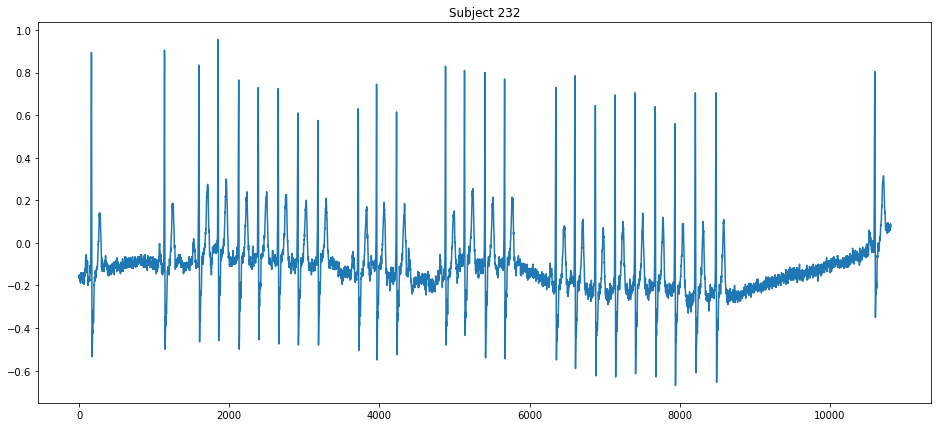

In [248]:
idx = 45
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx)

fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(record_sig[0][370000:380809])
#     draw_circle_with_annotation(ax1, (record_ann[0],record_sig[0][record_ann[0]]), ANN_DICT[record_ann_sym[0]])
# ax1.annotate(text=ANN_DICT[record_ann_sym[0]], xy=(record_ann[0],record_sig[0][record_ann[0]]),fontsize=15,ha="center")
# ax1.annotate(text=ANN_DICT[record_ann_sym[1]], xy=(record_ann[1],record_sig[0][record_ann[1]]),fontsize=15,ha="center")
plt.show()

In [245]:
# Beat Segment (Visualization)

# Beat Segement Points = median(prev_Rpeak, now_Rpeak) ~ median(now_Rpeak, next_Rpeak)
seg_points = []

"""
첫 rpeak는 next_Rpeak랑만 계산
"""
l_ann = len(record_ann)
last_points = len(record_sig[0])-1

N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []

for i in range(l_ann):
    
    now_r = record_ann[i]
    now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
    if now_sym[0] == "-":
        continue
    if i == 0: # 첫번째 예외처리
        next_r = record_ann[i+1]
        next_points = (next_r + now_r) // 2
        prev_points = 0
    elif i == l_ann-1: #마지막 예외처리
        prev_r = record_ann[i-1]
        prev_points = (prev_r + now_r) // 2
        next_points = last_points
    else: 
        prev_r = record_ann[i-1]
        next_r = record_ann[i+1]

        prev_points = (prev_r+now_r)//2
        next_points = (next_r+now_r)//2
    
    
    print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
    # Beat Segmentation
    if now_sym[0] == "N":
        N_Sig.append([prev_points,next_points])
    elif now_sym[0] == "S":
        S_Sig.append([prev_points,next_points])  
    elif now_sym[0] == "V":
        V_Sig.append([prev_points,next_points])
    elif now_sym[0] == "F":
        F_Sig.append([prev_points,next_points])
    elif now_sym[0] == "Q":
        Q_Sig.append([prev_points,next_points])
    
    
    

0 614 Size : 614 ('N', 0)
614 868 Size : 254 ('S', 1)
868 1329 Size : 461 ('S', 1)
1329 1781 Size : 452 ('N', 0)
1781 2029 Size : 248 ('S', 1)
2029 2353 Size : 324 ('S', 1)
2689 2947 Size : 258 ('N', 0)
2947 3366 Size : 419 ('S', 1)
3366 3788 Size : 422 ('N', 0)
3788 4210 Size : 422 ('S', 1)
4210 4631 Size : 421 ('N', 0)
4631 5046 Size : 415 ('S', 1)
5046 5462 Size : 416 ('N', 0)
5462 5719 Size : 257 ('S', 1)
5719 6168 Size : 449 ('S', 1)
6168 6601 Size : 433 ('N', 0)
6601 6851 Size : 250 ('S', 1)
6851 7107 Size : 256 ('S', 1)
7107 7362 Size : 255 ('S', 1)
7362 7623 Size : 261 ('S', 1)
7623 7878 Size : 255 ('S', 1)
7878 8129 Size : 251 ('S', 1)
8129 8598 Size : 469 ('S', 1)
8598 9415 Size : 817 ('N', 0)
9415 10092 Size : 677 ('N', 0)
10092 10417 Size : 325 ('N', 0)
10417 10668 Size : 251 ('S', 1)
10668 11129 Size : 461 ('S', 1)
11129 11583 Size : 454 ('N', 0)
11583 11839 Size : 256 ('S', 1)
11839 12105 Size : 266 ('S', 1)
12105 12364 Size : 259 ('S', 1)
12364 12619 Size : 255 ('S', 1)


In [254]:
N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []
def extract_Beats(record_ann,record_sig, record_ann_sym):
    global N_Sig, S_Sig, V_Sig, F_Sig, Q_Sig
    # Beat Segement Points = median(prev_Rpeak, now_Rpeak) ~ median(now_Rpeak, next_Rpeak)
    seg_points = []
    l_ann = len(record_ann)
    last_points = len(record_sig[0])-1
    max_len = -1
    min_len = 9999
    for i in range(l_ann):

        now_r = record_ann[i]
        now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
        if now_sym[0] == "-":
            continue
        if i == 0: # 첫번째 예외처리
            next_r = record_ann[i+1]
            next_points = (next_r + now_r) // 2
            prev_points = 0
        elif i == l_ann-1: #마지막 예외처리
            prev_r = record_ann[i-1]
            prev_points = (prev_r + now_r) // 2
            next_points = last_points
        else: 
            prev_r = record_ann[i-1]
            next_r = record_ann[i+1]

            prev_points = (prev_r+now_r)//2
            next_points = (next_r+now_r)//2

#         print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
        max_len = max(max_len, next_points-prev_points)
        min_len = min(min_len, next_points-prev_points)
        # Beat Segmentation
        if now_sym[0] == "N":
            N_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "S":
            S_Sig.append(record_sig[0][prev_points:next_points])  
        elif now_sym[0] == "V":
            V_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "F":
            F_Sig.append(record_sig[0][prev_points:next_points])
        elif now_sym[0] == "Q":
            Q_Sig.append(record_sig[0][prev_points:next_points])
    print("MAX LEN :",max_len,"MIN LEN :", min_len)

In [255]:
for idx in range(len(records_list)):
    record_sig, record_ann, record_ann_sym = extract_from_sbj(idx)
    extract_Beats(record_ann,record_sig,record_ann_sym)
    print("Complete_idx:",idx)

MAX LEN : 345 MIN LEN : 137
Complete_idx: 0
MAX LEN : 438 MIN LEN : 141
Complete_idx: 1
MAX LEN : 325 MIN LEN : 167
Complete_idx: 2
MAX LEN : 420 MIN LEN : 167
Complete_idx: 3
MAX LEN : 322 MIN LEN : 129
Complete_idx: 4
MAX LEN : 394 MIN LEN : 65
Complete_idx: 5
MAX LEN : 493 MIN LEN : 117
Complete_idx: 6
MAX LEN : 405 MIN LEN : 158
Complete_idx: 7
MAX LEN : 522 MIN LEN : 92
Complete_idx: 8
MAX LEN : 303 MIN LEN : 169
Complete_idx: 9
MAX LEN : 417 MIN LEN : 177
Complete_idx: 10
MAX LEN : 320 MIN LEN : 148
Complete_idx: 11
MAX LEN : 466 MIN LEN : 165
Complete_idx: 12
MAX LEN : 518 MIN LEN : 127
Complete_idx: 13
MAX LEN : 441 MIN LEN : 165
Complete_idx: 14
MAX LEN : 421 MIN LEN : 161
Complete_idx: 15
MAX LEN : 455 MIN LEN : 172
Complete_idx: 16
MAX LEN : 414 MIN LEN : 136
Complete_idx: 17
MAX LEN : 437 MIN LEN : 165
Complete_idx: 18
MAX LEN : 453 MIN LEN : 163
Complete_idx: 19
MAX LEN : 327 MIN LEN : 101
Complete_idx: 20
MAX LEN : 532 MIN LEN : 207
Complete_idx: 21
MAX LEN : 492 MIN LEN 

In [257]:
print(len(N_Sig))
print(len(S_Sig))
print(len(V_Sig))
print(len(F_Sig))
print(len(Q_Sig))

90386
3026
7236
803
8043


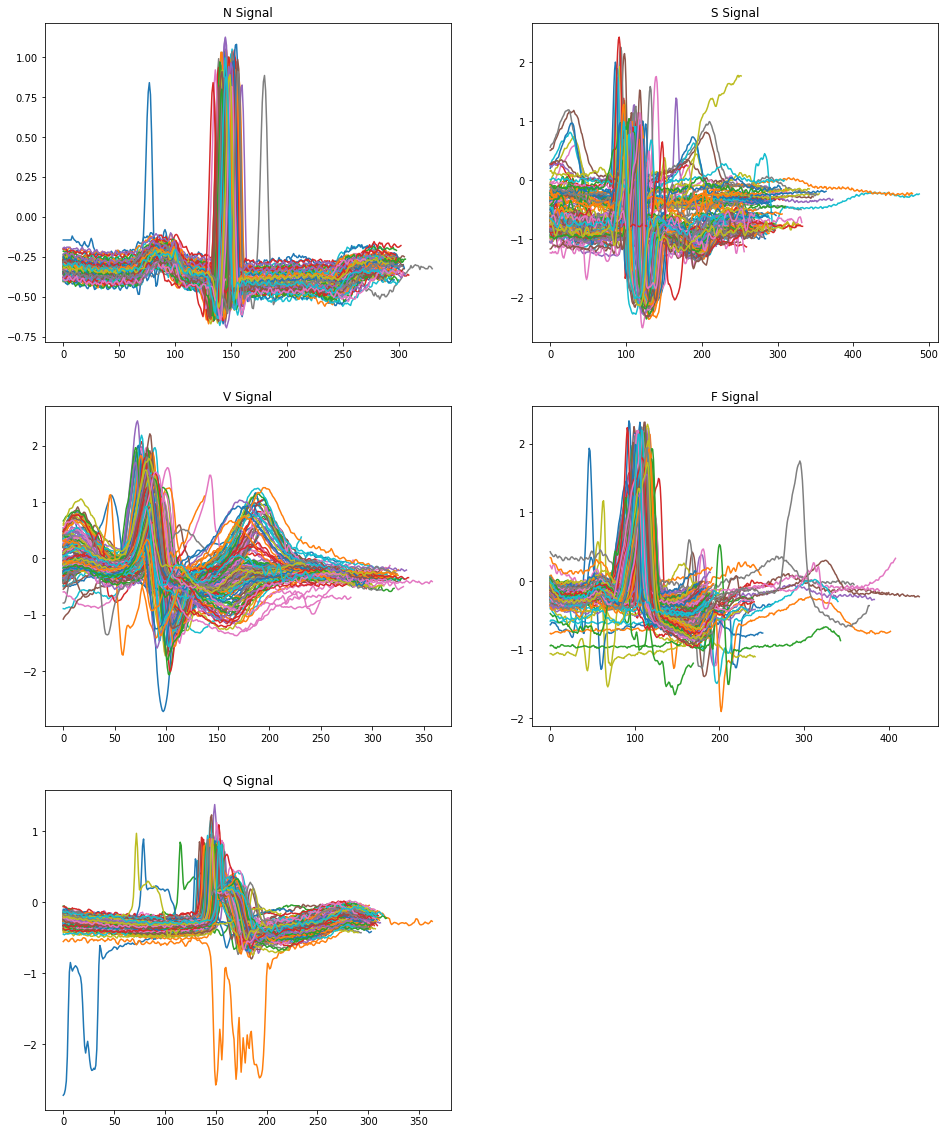

In [276]:
fig = plt.figure(figsize=(16,20))

target = 150

ax1 = fig.add_subplot(3,2,1)
ax1.set_title("N Signal")
count = 0
for sigs in N_Sig:
    if count == target:
        break
    ax1.plot(sigs)
    count+=1

ax2 = fig.add_subplot(3,2,2)
ax2.set_title("S Signal")
count = 0
for sigs in S_Sig:
    if count == target:
        break
    ax2.plot(sigs)
    count+=1
    
ax3 = fig.add_subplot(3,2,3)
ax3.set_title("V Signal")
count = 0
for sigs in V_Sig:
    if count == target:
        break
    ax3.plot(sigs)
    count+=1

ax4 = fig.add_subplot(3,2,4)
ax4.set_title("F Signal")
count = 0
for sigs in F_Sig:
    if count == target:
        break
    ax4.plot(sigs)
    count+=1

ax5 = fig.add_subplot(3,2,5)
ax5.set_title("Q Signal")
count = 0
for sigs in Q_Sig:
    if count == target:
        break
    ax5.plot(sigs)
    count+=1

In [209]:
# Visualization N,S,F,V,Q


In [153]:
# Compare Predict_Reulst with Annotation -> Visualization

In [ ]:
# offset = segment_start - annotation_xposition